In [1]:
from copy import deepcopy
import os
import random
import sys

In [2]:
from matplotlib import cm
from matplotlib.ticker import PercentFormatter
from mpl_toolkits.mplot3d.axes3d import Axes3D
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import toml
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchinfo

In [4]:
sys.path.append(os.path.join(sys.path[0], '../..'))

from endure.data.io import Reader
from endure.lcm.util import LCMEvalUtil
from endure.lcm.model.builder import LearnedCostModelBuilder
import endure.lcm.data.generator as Gen
from endure.ltune.data.generator import LTuneGenerator
from endure.lsm.types import Policy, LSMDesign, System
from endure.lsm.cost import EndureCost

In [5]:
model_path = '/data/models/lcm/qcost-10-19-v0/'
config = Reader.read_config(os.path.join(model_path, 'endure.toml'))
lsm_design = config['lsm']['design']

In [6]:
config['job']['LCMTrain']

{'max_epochs': 100,
 'save_dir': 'models/lcm/qcost-10-19-v0',
 'use_gpu_if_avail': True,
 'loss_fn': 'MSE',
 'optimizer': 'Adam',
 'lr_scheduler': 'CosineAnnealing',
 'no_checkpoint': False,
 'train': {'dir': 'train-data/qcost-t30',
  'format': 'parquet',
  'batch_size': 4096,
  'shuffle': True,
  'num_workers': 12,
  'drop_last': True},
 'test': {'dir': 'test-data/qcost-t30',
  'format': 'parquet',
  'batch_size': 65536,
  'shuffle': False,
  'num_workers': 4,
  'drop_last': True}}

In [7]:
lsm_design

'QLSM'

In [8]:
if lsm_design in ['Level', 'Tier']:
    gen = Gen.ClassicGenerator(config)
elif lsm_design == 'KLSM':
    gen = Gen.KHybridGenerator(config)
elif lsm_design in ['QLSM', 'QLSMIntegerVars']:
    gen = Gen.QCostGenerator(config)
else:
    gen = Gen.ClassicGenerator(config)

# Loss Graph

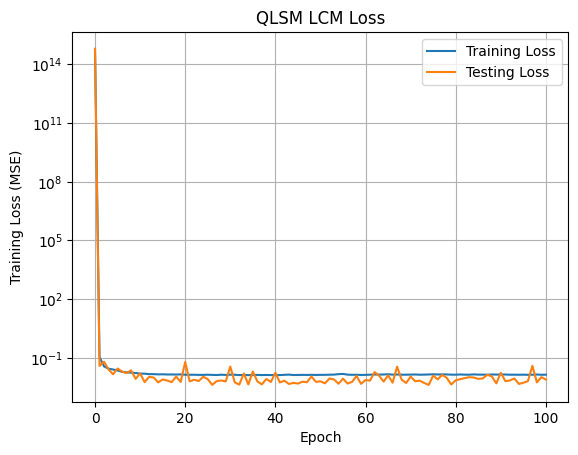

In [9]:
losses = pd.read_csv(os.path.join(model_path, 'losses.csv'))
losses = losses.loc[:100]
fig, ax = plt.subplots()
ax.plot(losses['epoch'], losses['train_loss'], label='Training Loss')
ax.plot(losses['epoch'], losses['test_loss'], label='Testing Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel(f'Training Loss ({config["job"]["LCMTrain"]["loss_fn"]})')
ax.set_yscale('log')
ax.grid()
ax.set_title(f'{lsm_design} LCM Loss')
_ = ax.legend()

In [10]:
losses.idxmin()

epoch          0
train_loss    34
test_loss     74
dtype: int64

# Building

## Model

In [11]:
model_name = os.path.join(model_path, 'best.model')
# model_name = os.path.join(model_path, 'checkpoints/epoch_02.checkpoint')
# last_checkpoint = os.listdir(os.path.join(model_path, 'checkpoints'))[-1]
# model_name = os.path.join(model_path, 'checkpoints', last_checkpoint)

builder = LearnedCostModelBuilder(config)
model = builder.build_model()
model_data = torch.load(model_name)
model_params = model_data['model_state_dict'] if model_name.endswith('checkpoint') else model_data
load_status = model.load_state_dict(model_params)
model.eval()
load_status

<All keys matched successfully>

In [12]:
torchinfo.summary(model, (1, 70), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
QModel                                   [1, 4]                    --
├─Linear: 1-1                            [1, 8]                    248
├─Linear: 1-2                            [1, 8]                    248
├─BatchNorm1d: 1-3                       [1, 26]                   52
├─Linear: 1-4                            [1, 32]                   864
├─ReLU: 1-5                              [1, 32]                   --
├─Dropout: 1-6                           [1, 32]                   --
├─Sequential: 1-7                        [1, 32]                   --
│    └─Linear: 2-1                       [1, 32]                   1,056
│    └─ReLU: 2-2                         [1, 32]                   --
│    └─Linear: 2-3                       [1, 32]                   1,056
│    └─ReLU: 2-4                         [1, 32]                   --
│    └─Linear: 2-5                       [1, 32]                   1,056
│  

# Utils

In [13]:
eval_util = LCMEvalUtil(config, model, gen)

In [14]:
wl = (z0, z1, q, w) = gen._sample_workload(4)
system = gen._sample_system()
design = gen._sample_design(system)
print(design)
print(system)
eval_util.cf.calc_cost(design, system, z0, z1, q, w), eval_util.eval_lcm(design, system, z0, z1, q, w)

LSMDesign(h=1.98, T=11, policy=<Policy.QFixed: 3>, Q=10, Y=1.0, Z=1.0, K=[])
System(E=4096, s=6.770801288983665e-08, B=8.0, N=980147458, H=5.620272402533823, phi=1.0)


(6.2148139681553225, 6.273807525634766)

In [15]:
eval_util.gen_random_sample()

({'z0': 0.041,
  'z1': 0.375,
  'q': 0.020000000000000018,
  'w': 0.5640000000000001,
  'B': 16.0,
  's': 9.429659607492747e-08,
  'E': 4096,
  'H': 6.398473217021391,
  'N': 252507889,
  'h': 1.356,
  'T': 20,
  'Q': 5,
  'cost_lcm': 1.60495924949646,
  'cost_acm': 1.6317982845579067},
 LSMDesign(h=1.356, T=20, policy=<Policy.QFixed: 3>, Q=5, Y=1.0, Z=1.0, K=[]),
 System(E=4096, s=9.429659607492747e-08, B=16.0, N=252507889, H=6.398473217021391, phi=1.0))

## LCM Evaluation

In [16]:
num_samples = 10000
table = []
bad = []
for _ in tqdm(range(num_samples)):
    row, design, system = eval_util.gen_random_sample()
    norm_delta = (row['cost_acm'] - row['cost_lcm']) / row['cost_acm']
    if (norm_delta < -1) or (norm_delta > 1):
        print(norm_delta, system, design, z0, z1, q, w)
        bad.append((norm_delta, z0, z1, q, w, design, system))
    table.append(deepcopy(row))
table = pd.DataFrame(table)
df = table

  0%|          | 0/10000 [00:00<?, ?it/s]

1.3328372673992632 System(E=2048, s=4.2330731923717454e-08, B=64.0, N=308865312, H=17.976012530672357, phi=1.0) LSMDesign(h=13.539, T=9, policy=<Policy.QFixed: 3>, Q=1, Y=1.0, Z=1.0, K=[]) 0.457 0.187 0.07699999999999996 0.279
-1.475380839646349 System(E=2048, s=3.398460825430804e-08, B=16.0, N=113176864, H=15.929784177025432, phi=1.0) LSMDesign(h=14.319, T=29, policy=<Policy.QFixed: 3>, Q=25, Y=1.0, Z=1.0, K=[]) 0.457 0.187 0.07699999999999996 0.279


In [17]:
df['delta'] = (df['cost_acm'] - df['cost_lcm'])
df['norm_delta'] = df['delta'] / df['cost_acm']
df.sort_values(by='norm_delta', ascending=False)

,z0,z1,q,w,B,s,E,H,N,h,T,Q,cost_lcm,cost_acm,delta,norm_delta
423,0.912,0.068,0.003,0.017,64.0,4.233073e-08,2048,17.976013,308865312,13.539,9,1,-0.028525,0.085701,0.114226,1.332837
5097,0.745,0.120,0.009,0.126,32.0,1.481147e-08,1024,16.367250,707789740,11.400,15,1,0.162884,0.261066,0.098182,0.376082
540,0.093,0.224,0.001,0.682,64.0,8.648518e-09,2048,17.721108,187076276,8.944,10,2,0.236559,0.373866,0.137307,0.367262
7614,0.305,0.021,0.003,0.671,64.0,8.040388e-09,2048,18.470941,288179432,8.244,13,7,0.114528,0.179566,0.065038,0.362194
5702,0.006,0.357,0.006,0.631,64.0,3.596751e-08,2048,10.994692,334358903,1.415,30,1,0.539163,0.844658,0.305495,0.361679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4444,0.736,0.230,0.020,0.014,16.0,6.041952e-08,8192,9.964587,384603571,1.488,26,1,1.101541,0.780762,-0.320779,-0.410853
5387,0.874,0.006,0.015,0.105,4.0,9.153457e-08,8192,13.854436,389410422,4.074,24,1,2.481558,1.653817,-0.827741,-0.500503
8767,0.093,0.007,0.026,0.874,64.0,7.210871e-08,1024,19.865872,859716992,8.311,3,1,0.469929,0.310746,-0.159184,-0.512265
6789,0.296,0.050,0.000,0.654,16.0,9.941053e-08,8192,12.541589,989561419,5.848,22,21,1.110572,0.729084,-0.381488,-0.523243


In [18]:
# cost, z0, z1, q, w, design, system = bad[0]
# z0, z1, q, w, design, system
# eval_util.cf.calc_cost(design, system, z0, z1, q, w), eval_util.eval_lcm(design, system, z0, z1, q, w)

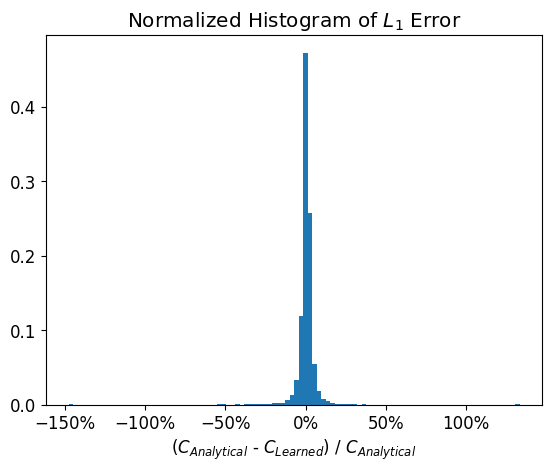

In [19]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots()
data = df['norm_delta'].values
ax.hist(data, bins=100, weights=np.ones_like(data)/len(data))
ax.set_xlabel('($C_{Analytical}$ - $C_{Learned}$) / $C_{Analytical}$')
ax.set_title('Normalized Histogram of $L_1$ Error')
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))

In [20]:
cutoff = 0.05
data = df[(df.norm_delta < cutoff) & (df.norm_delta > -cutoff)]
print(f'Percentange within {cutoff:.0%} delta: {len(data) / len(df):.3%}')

Percentange within 5% delta: 88.660%


In [21]:
data = df[(df.norm_delta < 0.05) & (df.norm_delta > -0.05)]
data.sort_values(by='norm_delta')

,z0,z1,q,w,B,s,E,H,N,h,T,Q,cost_lcm,cost_acm,delta,norm_delta
5685,0.010,0.156,0.045,0.789,8.0,7.331427e-08,4096,14.958830,902494162,2.665,4,1,2.514175,2.394825,-0.119349,-0.049836
786,0.645,0.108,0.222,0.025,32.0,6.884588e-08,1024,15.423514,144813550,5.777,4,2,1.952676,1.860183,-0.092493,-0.049722
5334,0.307,0.225,0.041,0.427,16.0,5.264977e-08,8192,7.290677,538473977,3.679,16,6,1.861265,1.773166,-0.088099,-0.049684
7589,0.001,0.860,0.085,0.054,128.0,2.434438e-08,1024,7.955140,735431090,1.110,15,5,3.159338,3.009935,-0.149403,-0.049637
9248,0.444,0.335,0.008,0.213,16.0,1.847253e-08,4096,15.763953,309285704,15.653,9,4,0.717962,0.684022,-0.033941,-0.049619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5919,0.340,0.540,0.045,0.075,4.0,4.389045e-08,8192,15.880909,321360520,5.733,28,15,2.684119,2.824774,0.140655,0.049793
5484,0.631,0.020,0.019,0.330,8.0,3.450825e-08,4096,11.707649,381168106,8.468,15,4,0.758381,0.798135,0.039754,0.049809
3597,0.617,0.113,0.132,0.138,32.0,7.618007e-09,1024,16.823521,974190302,13.197,15,5,1.483726,1.561598,0.077872,0.049867
5272,0.373,0.518,0.082,0.027,8.0,4.058325e-08,8192,12.753016,404574798,8.280,13,5,1.895103,1.994647,0.099544,0.049906


In [22]:
data = df[(df.norm_delta > 0.05) | (df.norm_delta < -0.05)]
data.sort_values(by='norm_delta')

,z0,z1,q,w,B,s,E,H,N,h,T,Q,cost_lcm,cost_acm,delta,norm_delta
9347,0.391,0.020,0.000,0.589,16.0,3.398461e-08,2048,15.929784,113176864,14.319,29,25,0.489419,0.197715,-0.291705,-1.475381
6789,0.296,0.050,0.000,0.654,16.0,9.941053e-08,8192,12.541589,989561419,5.848,22,21,1.110572,0.729084,-0.381488,-0.523243
8767,0.093,0.007,0.026,0.874,64.0,7.210871e-08,1024,19.865872,859716992,8.311,3,1,0.469929,0.310746,-0.159184,-0.512265
5387,0.874,0.006,0.015,0.105,4.0,9.153457e-08,8192,13.854436,389410422,4.074,24,1,2.481558,1.653817,-0.827741,-0.500503
4444,0.736,0.230,0.020,0.014,16.0,6.041952e-08,8192,9.964587,384603571,1.488,26,1,1.101541,0.780762,-0.320779,-0.410853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5702,0.006,0.357,0.006,0.631,64.0,3.596751e-08,2048,10.994692,334358903,1.415,30,1,0.539163,0.844658,0.305495,0.361679
7614,0.305,0.021,0.003,0.671,64.0,8.040388e-09,2048,18.470941,288179432,8.244,13,7,0.114528,0.179566,0.065038,0.362194
540,0.093,0.224,0.001,0.682,64.0,8.648518e-09,2048,17.721108,187076276,8.944,10,2,0.236559,0.373866,0.137307,0.367262
5097,0.745,0.120,0.009,0.126,32.0,1.481147e-08,1024,16.367250,707789740,11.400,15,1,0.162884,0.261066,0.098182,0.376082


In [23]:
def plot_workload_trend(df, trend='stune_T'):
    fig = plt.figure()
    ax = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
    fig.add_axes(ax)
    ax.set_xlim3d(0, 1), ax.set_ylim3d(1, 0), ax.set_zlim3d(0, 1)
    ax.set_xticks([0, 0.5, 1]), ax.set_yticks([0, 0.5, 1]), ax.set_zticks([0, 0.5, 1])
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.zaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    edge = ax.plot([0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], color='black', zorder=3)

    ax.set_xlabel('Point-Reads\n($z_0$ + $z_1$)', labelpad=15)
    ax.set_ylabel('Range-Reads (q)', labelpad=10)
    ax.set_zlabel('Writes (w)', labelpad=10)

    sc = ax.scatter(df['z0'] + df['z1'], df['q'], df['w'], c=df[trend], cmap='viridis')
    cbar = plt.colorbar(sc)
    cbar.set_label(trend)
    
    return fig, ax, sc, cbar

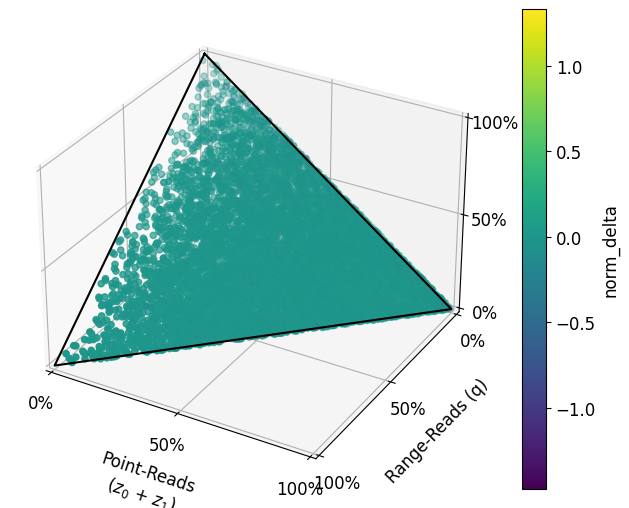

In [24]:
fig, ax, sc, cbar = plot_workload_trend(df, 'norm_delta')

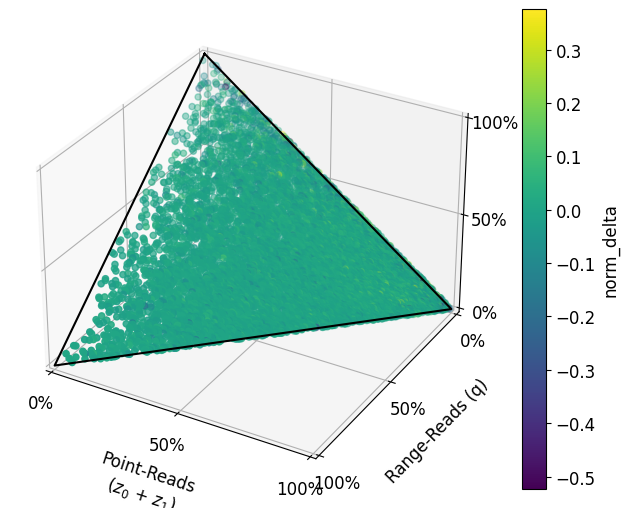

In [25]:
fig, ax, sc, cbar = plot_workload_trend(df[(df.norm_delta < 1) & (df.norm_delta > -1)], 'norm_delta')

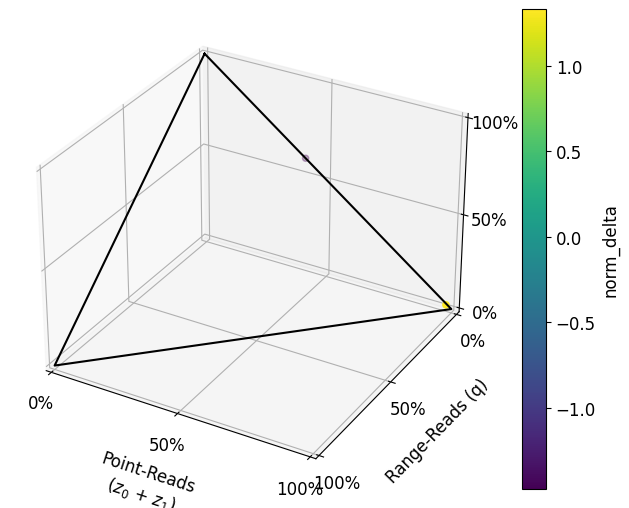

In [26]:
fig, ax, sc, cbar = plot_workload_trend(df[(df.norm_delta > 1) | (df.norm_delta < -1)], 'norm_delta')

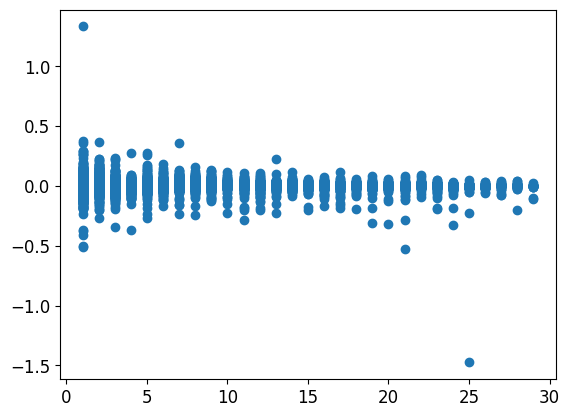

In [27]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots()
ax.scatter(df['Q'], df.norm_delta)
None